In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import csv
import pandas as pd
import random
from random import choice
from random import sample



In [2]:
# grap init
G_dblp = nx.Graph()


# dblp.tsv
with open('data/dblp/com-dblp/out.com-dblp.tsv', 'r') as file:
    for line in file:
        source, target = line.strip().split(' ')
        G_dblp.add_edge(int(source), int(target))

num_edges = G_dblp.number_of_edges()
num_nodes = G_dblp.number_of_nodes()


print("number of directed edges in dblp.tsv:", num_edges)
print("number of directed nodes in dblp.tsv:", num_nodes)

number of directed edges in dblp.tsv: 1049866
number of directed nodes in dblp.tsv: 317080


## Creating a fraction of graph for testing

In [3]:
# Define the fraction of nodes to include in the subgraph 
fraction = 0.05

# Get a subset of nodes based on the fraction
subset_nodes = list(G_dblp.nodes())[:int(fraction * len(G_dblp))]

# Create a subgraph using the subset of nodes
subgraph_dblp = G_dblp.subgraph(subset_nodes)

# Get the number of edges and nodes in the subgraph
num_edges_sub = subgraph_dblp.number_of_edges()
num_nodes_sub = subgraph_dblp.number_of_nodes()

# subgraph info:
# print("Subgraph Nodes:", subgraph_dblp.nodes())
# print("Subgraph Edges:", subgraph_dblp.edges())
print("-----" + "\n")
print("Number of edges in subgraph:", num_edges_sub)
print("Number of nodes in subgraph:", num_nodes_sub)


-----

Number of edges in subgraph: 72769
Number of nodes in subgraph: 15854


## Choosing random nodes for landmark

In [24]:
def generate_landmark_list(graph, num_landmarks=20):
    """
    Generate a list of random landmarks from the given graph.

    Parameters:
    - graph: NetworkX graph
    - num_landmarks: Number of landmarks to generate (default is 20)
    Returns:
    - landmark_list: List of random landmarks
    """
    landmark_list = []

    for i in range(num_landmarks):
        random_node = choice(list(graph.nodes()))
        if random_node not in landmark_list:
            landmark_list.append(random_node)

    return landmark_list

# Example usage:


landmark_list = generate_landmark_list(G_dblp, num_landmarks=100)
print("Landmark List:", landmark_list)


Landmark List: [116279, 292214, 85396, 97533, 256001, 253622, 179518, 189949, 11924, 179585, 189251, 115580, 270253, 304452, 213113, 114607, 290836, 122496, 76175, 124536, 121436, 253267, 50604, 172767, 178211, 181919, 142350, 1195, 143524, 284353, 179298, 177891, 262157, 122777, 201853, 42574, 277537, 300734, 70631, 178556, 224897, 76414, 314879, 301381, 222816, 142277, 176920, 265046, 36596, 202900, 284140, 259364, 1360, 94941, 74852, 285558, 157120, 173953, 97638, 156560, 131769, 295574, 310657, 238037, 177496, 58274, 85283, 217022, 16354, 110636, 48846, 47382, 201096, 53745, 80563, 63087, 284248, 14278, 74107, 20338, 165839, 234701, 115534, 109368, 30871, 234952, 80956, 214470, 836, 78783, 241311, 89507, 141502, 18469, 238671, 180631, 270899, 55915, 199328, 249974]


## Calculating each node's degree

In [17]:
# Top 20 degree nodes regardless of area of repulsion
N = 20

# Get the top nodes with the highest degree
top_nodes_degree = [node for node in sorted(G_dblp.nodes(), key=G_dblp.degree, reverse=True)][:N]

# Print the degree for each of the top nodes
for node in top_nodes_degree:
    node_degree = G_dblp.degree(node)
    print(f"The degree of node {node} is {node_degree}")



The degree of node 3336 is 343
The degree of node 3345 is 296
The degree of node 167 is 290
The degree of node 14690 is 269
The degree of node 13941 is 264
The degree of node 30095 is 244
The degree of node 13842 is 230
The degree of node 865 is 227
The degree of node 3298 is 225
The degree of node 13811 is 221
The degree of node 15326 is 219
The degree of node 3346 is 218
The degree of node 3326 is 218
The degree of node 1827 is 215
The degree of node 1833 is 215
The degree of node 13953 is 215
The degree of node 45 is 208
The degree of node 7227 is 207
The degree of node 2486 is 201
The degree of node 6319 is 201


In [22]:
def get_top_nodes_degree(graph, N=20):
    """"
    Get the top N nodes with the highest degree.
    Check if the previous node is a neighbor of the current node. (k=1 by default)
    If not, add the current node to the list of selected nodes. 

    Parameters:
    - graph: NetworkX graph (subgraph)
    """"
    selected_nodes = []
    top_nodes_degree = [node for node in sorted(graph.nodes(), key=graph.degree, reverse=True)]

    for node in top_nodes_degree:
        if not any(prev_node in graph.neighbors(node) for prev_node in selected_nodes):
            selected_nodes.append(node)
            if len(selected_nodes) == N:
                break

    for node in selected_nodes:
        print(f'Node: {node}, Degree: {graph.degree(node)}')

# Example usage:
get_top_nodes_degree(G_dblp)


Node: 3336, Degree: 343
Node: 14690, Degree: 269
Node: 13941, Degree: 264
Node: 30095, Degree: 244
Node: 13842, Degree: 230
Node: 865, Degree: 227
Node: 13811, Degree: 221
Node: 15326, Degree: 219
Node: 1827, Degree: 215
Node: 1833, Degree: 215
Node: 45, Degree: 208
Node: 27138, Degree: 201
Node: 1448, Degree: 191
Node: 9401, Degree: 184
Node: 7007, Degree: 183
Node: 9800, Degree: 182
Node: 10278, Degree: 182
Node: 3300, Degree: 181
Node: 2006, Degree: 180
Node: 66102, Degree: 175


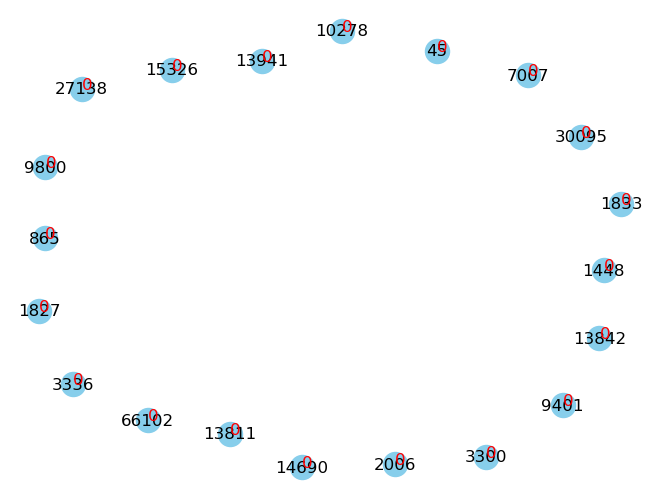

In [16]:
import matplotlib.pyplot as plt

# Define the number of top nodes to print
N = 20



# Create a subgraph with only the top nodes
H = G_dblp.subgraph(selected_nodes)

# Draw the graph
pos = nx.spring_layout(H)
nx.draw(H, pos, with_labels=True, node_color='skyblue')

# Draw the node degree on the graph
node_degree = nx.degree(H)
for node, degree in node_degree:
    plt.text(pos[node][0], pos[node][1], str(degree), fontsize=12, color='red')

plt.show()

## Calculate each's node closeness centrality (approximation)

In [ ]:
def approximate_closeness_centrality(graph, num_seeds=10):
    # Select a sample of random seed nodes
    seed_nodes = sample(graph.nodes(), num_seeds)

    # Initialize the closeness centrality dictionary
    approx_closeness_centrality = {node: 0.0 for node in graph.nodes()}

    # Perform BFS computations from each seed node
    for seed_node in seed_nodes:
        distances = nx.single_source_shortest_path_length(graph, seed_node)
        for node, distance in distances.items():
            approx_closeness_centrality[node] += distance

    # Normalize the closeness centrality by the number of seed nodes
    for node in graph.nodes():
        approx_closeness_centrality[node] /= num_seeds

    return approx_closeness_centrality

In [ ]:
# # Example usage on fraction of graph
# subgraph_dblp = nx.subgraph(G_dblp, subset_nodes)  
# num_seeds = 100  # Adjust as needed

# # Calculate approximate closeness centrality for each node
# approx_closeness_centrality = approximate_closeness_centrality(subgraph_dblp, num_seeds)

# # Count the number of nodes with zero closeness centrality
# num_nodes_with_zero_centrality = sum(1 for centrality in approx_closeness_centrality.values() if centrality == 0)

# # Get the bottom nodes with the lowest approximate closeness centrality and non-zero centrality
# bottom_nodes_closeness = [node for node in sorted(approx_closeness_centrality, key=approx_closeness_centrality.get) if approx_closeness_centrality[node] > 0][:N]

# # Print the approximate closeness centrality for each of the bottom nodes
# for node in bottom_nodes_closeness:
#     centrality = approx_closeness_centrality[node]
#     print(f"The approximate closeness centrality of node {node} is {centrality}")

# # Print the count of nodes with zero closeness centrality
# print(f"Number of nodes with zero closeness centrality: {num_nodes_with_zero_centrality}")

In [ ]:
# Whole graph closeness
num_seeds = 20  

# Calculate approximate closeness centrality for each node
approx_closeness_centrality = approximate_closeness_centrality(G_dblp, num_seeds)

# Count the number of nodes with zero closeness centrality
num_nodes_with_zero_centrality = sum(1 for centrality in approx_closeness_centrality.values() if centrality == 0)

# Get the bottom nodes with the lowest approximate closeness centrality and non-zero centrality
bottom_nodes_closeness = [node for node in sorted(approx_closeness_centrality, key=approx_closeness_centrality.get) if approx_closeness_centrality[node] > 0][:N]

# Print the approximate closeness centrality for each of the bottom nodes
for node in bottom_nodes_closeness:
    centrality = approx_closeness_centrality[node]
    print(f"The approximate closeness centrality of node {node} is {centrality}")

# Print the count of nodes with zero closeness centrality
print(f"Number of nodes with zero closeness centrality: {num_nodes_with_zero_centrality}")

/var/folders/28/tw9kr3yd4h950rswblzvqc9h0000gn/T/ipykernel_96136/302520595.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  seed_nodes = sample(graph.nodes(), num_seeds)


The approximate closeness centrality of node 167 is 4.65
The approximate closeness centrality of node 4306 is 4.7
The approximate closeness centrality of node 35572 is 4.7
The approximate closeness centrality of node 2021 is 4.75
The approximate closeness centrality of node 4807 is 4.75
The approximate closeness centrality of node 6341 is 4.75
The approximate closeness centrality of node 3330 is 4.75
The approximate closeness centrality of node 1972 is 4.75
The approximate closeness centrality of node 2175 is 4.75
The approximate closeness centrality of node 1830 is 4.8
The approximate closeness centrality of node 3336 is 4.8
The approximate closeness centrality of node 7430 is 4.8
The approximate closeness centrality of node 13842 is 4.8
The approximate closeness centrality of node 29720 is 4.8
The approximate closeness centrality of node 3300 is 4.8
The approximate closeness centrality of node 45 is 4.85
The approximate closeness centrality of node 2006 is 4.85
The approximate closen

## Calculate each's node betweeness centrality

In [ ]:
def approximate_betweenness_centrality(graph, num_seeds=10):
    # Select a sample of random seed nodes
    seed_nodes = sample(graph.nodes(), num_seeds)

    # Initialize the betweenness centrality dictionary
    approx_betweenness_centrality = {node: 0.0 for node in graph.nodes()}

    # Perform BFS computations from each seed node and accumulate dependencies
    for seed_node in seed_nodes:
        paths = nx.single_source_shortest_path(graph, source=seed_node)
        dependencies = {node: 0 for node in graph.nodes()}

        for path in paths.values():
            for node in path[1:-1]:  # Exclude the source and target nodes
                dependencies[node] += 1

        # Accumulate betweenness centrality using dependencies
        for node in graph.nodes():
            if node != seed_node:
                approx_betweenness_centrality[node] += dependencies[node]

    # Normalize the betweenness centrality by the number of seed nodes
    for node in graph.nodes():
        approx_betweenness_centrality[node] /= num_seeds

    return approx_betweenness_centrality


In [ ]:
# Whole graph betweenness
num_seeds = 20

# Calculate approximate betweenness centrality for each node
approx_betweenness_centrality = approximate_betweenness_centrality(G_dblp, num_seeds)

# Count the number of nodes with zero betweenness centrality
num_nodes_with_zero_centrality = sum(1 for centrality in approx_betweenness_centrality.values() if centrality == 0)

# Get the top nodes with the highest approximate betweenness centrality and non-zero centrality
top_nodes_between = [node for node in sorted(approx_betweenness_centrality, reverse=True, key=approx_betweenness_centrality.get) if approx_betweenness_centrality[node] > 0][:N]

# Print the approximate betweenness centrality for each of the top nodes
for node in top_nodes_between:
    centrality = approx_betweenness_centrality[node]
    print(f"The approximate betweenness centrality of node {node} is {centrality}")

# Print the count of nodes with zero betweenness centrality
print(f"Number of nodes with zero betweenness centrality: {num_nodes_with_zero_centrality}")

/var/folders/28/tw9kr3yd4h950rswblzvqc9h0000gn/T/ipykernel_96136/2477495707.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  seed_nodes = sample(graph.nodes(), num_seeds)


The approximate betweenness centrality of node 19741 is 15975.45
The approximate betweenness centrality of node 161387 is 15881.6
The approximate betweenness centrality of node 41719 is 15877.35
The approximate betweenness centrality of node 133007 is 15872.15
The approximate betweenness centrality of node 207952 is 15869.8
The approximate betweenness centrality of node 60061 is 15867.05
The approximate betweenness centrality of node 19972 is 15862.8
The approximate betweenness centrality of node 207430 is 15858.95
The approximate betweenness centrality of node 161386 is 15856.65
The approximate betweenness centrality of node 112139 is 15855.75
The approximate betweenness centrality of node 194301 is 15819.4
The approximate betweenness centrality of node 38607 is 15721.75
The approximate betweenness centrality of node 1197 is 15706.9
The approximate betweenness centrality of node 93135 is 15696.5
The approximate betweenness centrality of node 37940 is 15281.95
The approximate betweenne

## Area of repulsion